In [1]:
### https://github.com/s-mostafa-a/Luna16/blob/master/notebooks/Preprocessor.ipynb

In [2]:
import SimpleITK as sitk
import numpy as np
import glob
from matplotlib import pyplot as plt
import scipy
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from skimage.filters import roberts
from skimage.morphology import convex_hull_image, disk, binary_closing
from tqdm import tqdm


### running into a single exam

In [3]:
def load_itk(filename):
    itkimage = sitk.ReadImage(filename)
    image_array = sitk.GetArrayFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return image_array, origin, spacing    

In [4]:
INPUT_FOLDER = r'D:/masters_datasets/LUNA16-original/LUNA16_Images/*.mhd'
file_list = glob.glob(INPUT_FOLDER)
print(len(file_list))
file_list.sort()

888


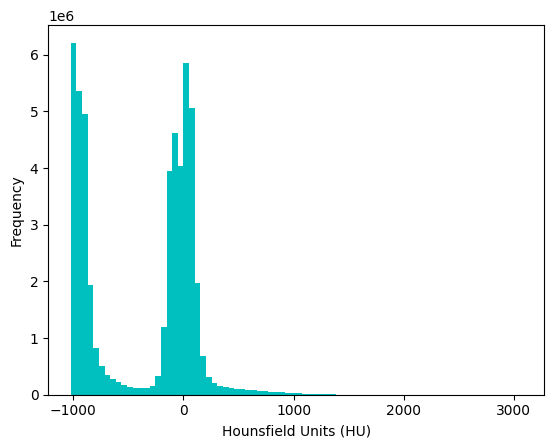

In [5]:
img, origin, spacing = load_itk(file_list[0])
first_patient_pixels = img
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [6]:
def resample(image, previous_spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(previous_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [7]:
img2, spacing2 = resample(img, spacing)

C:\Users\ejrza\AppData\Local\Temp\ipykernel_6768\1495026643.py:10: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


In [8]:
print(img.shape, spacing)
print(img2.shape, spacing2)

(194, 512, 512) [1.79999995 0.64453125 0.64453125]
(349, 330, 330) [1.00057304 1.         1.        ]


In [9]:
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    plt_number = 0
    # Original image label: 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    # Step 1: Convert into a binary image.
    # image label: 1
    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 2: Remove the blobs connected to the border of the image.
    # image label: 2
    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
    # Step 3: Label the image.
    # image label: 3
    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1

    # Step 4: Keep the labels with 2 largest areas and segment two lungs.
    # image label: 4
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!
    # image labels: 5, 6
    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1

    # Step 6: convex hull of each lung
    # image labels: 7, 8
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
    # Step 7: joint two separated right and left lungs.
    # image label: 9
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 8: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    # image label: 10
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 9: Superimpose the binary mask on the input image.
    # image label: 11
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    # return im
    return binary * 1

In [10]:
# tmp_2d_img = get_segmented_lungs(img2[200,:,:], True)

In [11]:
img3 = np.asarray([get_segmented_lungs(im) for im in img2])

C:\Users\ejrza\AppData\Local\Temp\ipykernel_6768\1285640923.py:81: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  l = convex_hull_image(l)


In [12]:
# plt.imshow(img3[201,:,:], cmap=plt.cm.bone)
# plt.show()

In [13]:
# plt.imshow(first_patient_pixels[int(201*733/366),:,:], cmap=plt.cm.bone)
# plt.show()

In [14]:
def normalize(image):
    MIN_BOUND = -1200
    MAX_BOUND = 600.
    image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image2[image2 > 1] = 1.
    image2[image2 < 0] = 0.
    image2 *= 255.
    return image2

In [15]:
img4 = normalize(img3)

In [16]:
# plt.imshow(img4[201,:,:], cmap=plt.cm.bone)
# plt.show()

In [17]:
def zero_center(image):
    PIXEL_MEAN = 0.25 * 256
    image2 = image - PIXEL_MEAN
    return image2

In [18]:
img5 = zero_center(img4)

In [19]:
# plt.imshow(img5[200,:,:], cmap=plt.cm.bone)
# plt.show()

### running into multiple exams and saving resulting masks and preview

In [20]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
import matplotlib

for file in tqdm(file_list):
    img, origin, spacing = load_itk(file)
    img2, spacing2 = resample(img, spacing)
    img3 = np.asarray([get_segmented_lungs(im) for im in img2])

    raw_name = file.split('\\')[-1].split('.mhd')[0]

    # print(img3.shape)
    # print(np.unique(img3, return_counts=True))

    ### visualize generated masks

    if not os.path.exists('preview/' + raw_name + 'png'):
        p = img3.transpose(2, 1, 0)
        verts, faces, normals, values = measure.marching_cubes(p, 0)

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        mesh = Poly3DCollection(verts[faces], alpha=0.20)
        face_color = [0.45, 0.45, 0.75]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

        ax.set_xlim(0, p.shape[0])
        ax.set_ylim(0, p.shape[1])
        ax.set_zlim(0, p.shape[2])

        plt.savefig('preview/' + raw_name + '.png')
        plt.close()
        matplotlib.use('Agg')

    ### saving masks
    current_name = raw_name + '.nrrd'
    if not os.path.exists(current_name):
        ma = sitk.GetImageFromArray(img3)
        sitk.WriteImage(
            ma,
            'output/' + current_name, True
        )

  0%|          | 0/888 [00:00<?, ?it/s]C:\Users\ejrza\AppData\Local\Temp\ipykernel_6768\1495026643.py:10: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
C:\Users\ejrza\AppData\Local\Temp\ipykernel_6768\1285640923.py:81: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  l = convex_hull_image(l)
  3%|▎         | 25/888 [41:31<22:54:52, 95.59s/it] C:\Users\ejrza\AppData\Local\Temp\ipykernel_6768\1285640923.py:80: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  r = convex_hull_image(r)
100%|██████████| 888/888 [30:43:53<00:00, 124.59s/it]   


In [21]:
### perform the same resampling into coordinates
### run code to verify if all coordinates fit the lungs found 